<a href="https://colab.research.google.com/github/francescodalmonte/Computer-Vision-miscellanea/blob/main/STPM_for_AD_demo-new_ds5k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STPM implementation and testing on a custom Dataset**

[[Student-Teacher features Pyramid Matching for Unsupervised AD - G. Wang et al. (arxiv)]](https://arxiv.org/abs/2103.04257v2)

STPM (*Student-Teacher features Pyramid Matching*) is a particular Knowledge Distillation-based technique designed for image Anomaly Detection task. As many other existing KD-based AD techniques, it relies on a Student-Teacher network architecture, in which the knowledge of the pre-trained teacher is distilled into an "uninformed" student network by forcing the latter to simulate teacher's output activations when nominal images examples are submitted to them; being only trained on nominal samples, we expect the student network to produce unexpected outputs when dealing with the anomalous ones. This means that the differences between teacher's and student's activations can be effectively used as an estimator of the anomaly score of input images.

In STPM the student network has the same architecture of the teacher's (they're both based on ResNet18 backbones), and it is trained to mimic its activations at different levels of the architecture (not only the inal output, but a *pyramid* of features is compared during training).

According to the authors, this *multi-scale features matching strategy* enables the student to receive a mixture of multi-level knowledge, allowing to detect more and more various anomalies.



This notebook provides an example of basic **re-implementation of the STPM model** (*Section 1*) and a **demonstration of training on the *FilterCloths* custom dataset** (*Sections 2 to 5*). This Dataset contains 2k normal and anomalous 224x224px images from a real-world industrial vision inspection system.

Author: *Francesco Dalmonte, francesco.dalmonte7@unibo.it*

## Section 0: **Set-up runtime and dependencies**

In [ ]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
!pip install scikit-learn==1.3.2
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from scipy.ndimage import gaussian_filter

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torchvision.transforms import v2 as T2
from torchvision import transforms as T
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.resnet import conv3x3, conv1x1, BasicBlock, Bottleneck

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# load the dataset to local memory

from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/Colab_Notebooks/progetto_asperti/ds5k_diffrad_CABE_SUB_yellow.zip" "ds5k_diffrad_CABE_SUB_yellow.zip"
!unzip --qq ds5k_diffrad_CABE_SUB_yellow.zip

Mounted at /content/drive


## Section 1: **Modified ResNet18 class**

In [ ]:
# This is the class of the modified ResNet18 architecture which will be used
# for both student's and teacher's networks.

class MResNet18(nn.Module):
    def __init__(self, block, layers, num_classes=1000, groups=1,
                 width_per_group=64, downscale=False):
        super(MResNet18, self).__init__()

        self._norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.downscale = downscale


        # modules initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)


# the output activations from each of the 3 blocks are returned at each forward-pass
# (these are the activations that will be compared to compute the anomaly maps)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)

        return x1, x2, x3

In [ ]:
# function to easily instantiate the models

def modified_resnet18(pretrained, **kwargs):
    model = MResNet18(block = BasicBlock, layers = [2,2,2,2], **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(ResNet18_Weights.IMAGENET1K_V1.url, progress = True)
        model.load_state_dict(state_dict, strict=False)
    return model

## Section 2: **FilterClothsDataset class**

In [ ]:
from torchvision import tv_tensors

num_workers = 0
pin_memory = True
batch_size = 256
data_path = "ds5k_diffrad_CABE_SUB_yellow"

In [ ]:
class FilterClothsDataset(Dataset):
    def __init__(self,
                 data_path: str,
                 is_train: bool,
                 resize: int = 224,
                 cropsize: int = 224):
        self.data_path = data_path
        self.is_train = is_train
        self.resize = resize
        self.cropsize = cropsize

        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()

        # set_transforms
        if self.is_train:
            self.transform_v2 = T2.Compose([T2.Resize(resize, Image.BILINEAR),
                                            T2.Normalize(mean=[128., 128., 128.],
                                                         std=[50., 50., 50.]),
                                            T2.RandomHorizontalFlip(p=0.5),
                                            T2.RandomVerticalFlip(p=0.5),
                                            T2.RandomResizedCrop(resize, scale=(0.3, 1.0), ratio=(0.8, 1.2))
                                            ])
        else:
            self.transform_v2 = T2.Compose([T2.Resize(resize, Image.BILINEAR),
                                            T2.Normalize(mean=[128., 128., 128.],
                                                         std=[50., 50., 50.]),
                                            T2.RandomHorizontalFlip(p=0.5),
                                            T2.RandomVerticalFlip(p=0.5)
                                            ])

    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]

        if y == 0:
            mask = np.zeros([1, self.cropsize, self.cropsize])
        else:
            mask = Image.open(mask).convert("L")
        mask = tv_tensors.Mask(mask)

        x = Image.open(x).convert('RGB')
        x = tv_tensors.Image(x, dtype=torch.float)

        x, mask = self.transform_v2(x, mask)

        return x, y, mask


    def __len__(self):
        return len(self.x)


    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []

        img_dir = os.path.join(self.data_path, "custom", phase, "tele")
        gt_dir = os.path.join(self.data_path, "custom", phase+"_maps", "tele")

        classes = sorted(os.listdir(img_dir))
        for cl in classes:
            # load images
            img_class_dir = os.path.join(img_dir, cl)
            img_fpath_list = sorted([os.path.join(img_class_dir, f) for f in os.listdir(img_class_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)

            # load gt maps
            if cl == 'normal':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, cl)
                img_fname_list = [os.path.basename(fp) for fp in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, fn) for fn in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        return list(x), list(y), list(mask)


In [ ]:
# instantiate train and test datasets
train_ds_tot = FilterClothsDataset(data_path, is_train=True, resize=224, cropsize=224)
test_ds = FilterClothsDataset(data_path, is_train=False, resize=224, cropsize=224)

# validation split
# (in an AD task usually there is no risk of overtraining. However, a validation set
# can used to assess the model capability to generalize its behaviour to new normal samples)
img_nums = len(train_ds_tot)
valid_num = int(img_nums * 0.1)
train_num = img_nums - valid_num
train_ds, val_ds = torch.utils.data.random_split(train_ds_tot, [train_num, valid_num])

# dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                       shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                     shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                     shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


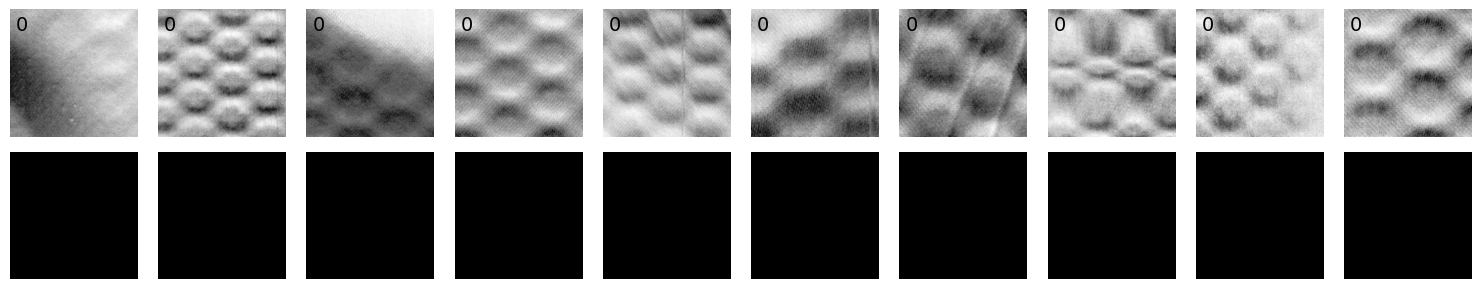

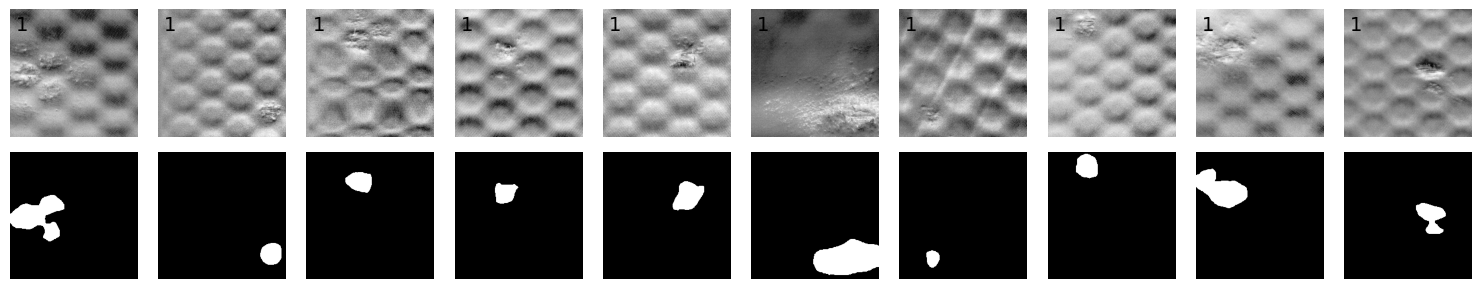

In [ ]:
def plot_examples(dataloader, N=10):
    fig, ax = plt.subplots(ncols=N, nrows=2, figsize=(N*1.5,3), tight_layout=True)
    x, y, mask = next(iter(dataloader))
    for i in range(N):
        ax[0,i].imshow(x[i][0], cmap="Greys"); ax[0,i].axis("off")
        ax[0,i].text(s=f"{y[i].numpy()}", x=10, y=10, verticalalignment="top", fontsize=14)
        ax[1,i].imshow(mask[i][0], cmap="Greys_r"); ax[1,i].axis("off")

plot_examples(train_dl)
plot_examples(test_dl)

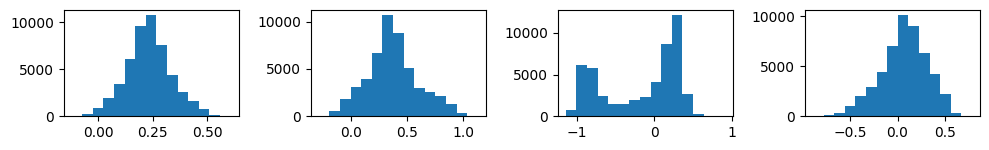

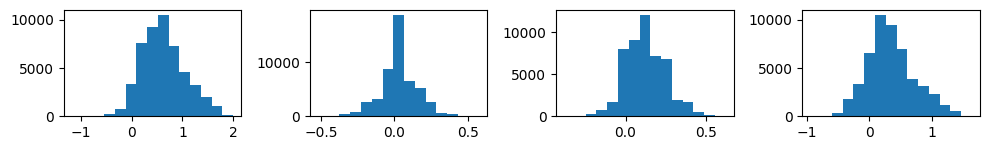

In [ ]:
def plot_examples_histograms(dataloader, N=4):
    fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*2.5,1.6), tight_layout=True)
    x, y, mask = next(iter(dataloader))
    for i in range(N):
        ax[i].hist(x[i][0].reshape(-1)[:], bins=15)

plot_examples_histograms(train_dl)
plot_examples_histograms(test_dl)

## Section 3: **Training functions**

In [ ]:
def L2dist_norm(array1, array2):
    """L2 distance between normalized features maps."""
    array1_norm = F.normalize(array1, p=2) # features vectors are L2 normalized at each "pixel" position
    array2_norm = F.normalize(array2, p=2)

    L2dist = 0.5 * ((array1_norm - array2_norm)**2).sum(axis=1)

    return L2dist

In [ ]:
def total_loss(t_features, s_features, batch_avg=True):
    """Compute the total loss by comparing teacher's and student's
    output features (used L2dist_norm).

    If batch_avg == True this function returns a single value representing
    the average over all the images in the batch (used during training);
    otherwise, the output is a list of image-wise average loss values.
    """

    tot_loss = 0 if batch_avg else []

    N = len(t_features)
    for tf, sf in zip(t_features, s_features):
        b, c, h, w = tf.shape

        loss = L2dist_norm(tf, sf)

        if batch_avg:
            loss = loss.mean(dim=(0,1,2))
            tot_loss+=loss

        else:
            loss = loss.mean(dim=(1,2))
            tot_loss.append(loss.cpu().detach().numpy())

    if batch_avg:
        tot_loss/=N
    else:
        tot_loss = np.array(tot_loss)
        tot_loss = np.mean(tot_loss, axis=0)

    return tot_loss

In [ ]:
def compute_anomaly_maps(t_features,
                         s_features,
                         out_size: int = 224):
    """Compute anomaly maps by interpolating the features-distance maps
    at different levels of the "pyramid""."""

    anomaly_maps = []

    for tf, sf in zip(t_features, s_features):
        loss = L2dist_norm(tf, sf)
        anomaly_map = F.interpolate(loss.unsqueeze(1),
                                    size=out_size,
                                    mode='bilinear',
                                    align_corners=False
                                    )

        anomaly_maps.append(anomaly_map.squeeze().cpu().detach().numpy())

    anomaly_maps = np.array(anomaly_maps).mean(axis=0)

    return anomaly_maps

In [ ]:
def train_step(model_t,
               model_s,
               dataloader,
               device,
               optimizer,
               log_interval=-1):
    """Train the model for one epoch."""

    loss_super = []
    n_samples_super = []

    model_s.train() # only student model is trained

    for idx_batch, (x, y, mask) in enumerate(dataloader):
        n_samples = len(y)

        # forward pass
        optimizer.zero_grad()
        features_t = model_t(x.to(device))
        features_s = model_s(x.to(device))
        loss = total_loss(features_s, features_t)

        # backward pass
        loss.backward()
        optimizer.step()

        # log and store current values
        n_samples_super.append(n_samples)
        loss_super.append(loss.cpu().detach().numpy()*n_samples)

        if log_interval>0:
            if idx_batch%log_interval==0:
                print(f"TRAIN batch {idx_batch}/{len(dataloader)} - loss: {loss}")

    return {"avg_loss": np.sum(loss_super)/np.sum(n_samples_super)}

In [ ]:
def val_step(model_t,
             model_s,
             dataloader,
             device):
    """Single model validation step."""

    loss_super = []
    n_samples_super = []

    model_s.eval()

    with torch.no_grad():
        for idx_batch, (x, y, mask) in enumerate(dataloader):
            n_samples = len(y)

            # forward pass
            features_t = model_t(x.to(device))
            features_s = model_s(x.to(device))
            loss = total_loss(features_s, features_t)

            # log and store current values
            n_samples_super.append(n_samples)
            loss_super.append(loss.cpu().detach().numpy()*n_samples)

    return {"avg_loss": np.sum(loss_super)/np.sum(n_samples_super)}

In [ ]:
def train_loop(model_t,
               model_s,
               train_loader,
               val_loader,
               device,
               num_epochs,
               optimizer,
               name_train,
               log_interval=-1,
               lr_scheduler=None,
               verbose=True):
    """Executes the training-evaluation loop."""

    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')

    losses_train = []
    losses_val = []

    best_val = np.inf

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # train step
        train_dict = train_step(model_t, model_s, train_loader,
                                device, optimizer, log_interval)

        # val step
        val_dict = val_step(model_t, model_s, val_loader, device)

        # store results
        losses_train.append(train_dict["avg_loss"])
        losses_val.append(val_dict["avg_loss"])

        lr = optimizer.param_groups[0]['lr']

        if lr_scheduler is not None:
            lr_scheduler.step()

        # save checkpoint if perfosmances improved on val set
        if val_dict["avg_loss"] < best_val:
            best_val = val_dict["avg_loss"]
            torch.save(model_s.state_dict(), f"checkpoints/{name_train}.ckpt")
            msg = " (**ckpt)"
        else:
            msg = " "

        if verbose:
            elapsed = time.time()-start_time
            print(f"Epoch: {epoch} - TRAIN loss: {train_dict['avg_loss']:.6f} - VAL loss: {val_dict['avg_loss']:.6f} - LR: {lr:.6f}" , end=" - ")
            print(f"elapsed time: {elapsed:.4f} s {msg}")

    return {"losses_train": losses_train,
            "losses_val": losses_val
            }

## Section 4: **Train model**

In [ ]:
# instantiate models
teacher_net = modified_resnet18(pretrained=True).to(device)
student_net = modified_resnet18(pretrained=False).to(device)

for param in teacher_net.parameters():
    param.requires_grad = False
_ = teacher_net.eval() # teacher model will always remain in eval mode

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [ ]:
# MISS: Hyperparameter optimization strategy (these parameters were manually tuned)

name_train = "KD_student"
num_epochs = 170
lr = 0.055
optimizer = torch.optim.Adam(student_net.parameters(), lr=lr, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [20, 50, 80, 120, 160], gamma=0.15)

In [ ]:
train_dict = train_loop(teacher_net,
                        student_net,
                        train_dl,
                        val_dl,
                        device,
                        num_epochs,
                        optimizer,
                        name_train = name_train,
                        log_interval=-1,
                        lr_scheduler=lr_scheduler,
                        verbose=True)

Epoch: 1 - TRAIN loss: 0.233079 - VAL loss: 0.199804 - LR: 0.055000 - elapsed time: 43.0458 s  (**ckpt)
Epoch: 2 - TRAIN loss: 0.127376 - VAL loss: 0.179342 - LR: 0.055000 - elapsed time: 34.6187 s  (**ckpt)
Epoch: 3 - TRAIN loss: 0.102825 - VAL loss: 0.168550 - LR: 0.055000 - elapsed time: 36.2677 s  (**ckpt)
Epoch: 4 - TRAIN loss: 0.091081 - VAL loss: 0.170095 - LR: 0.055000 - elapsed time: 34.6202 s  
Epoch: 5 - TRAIN loss: 0.087539 - VAL loss: 0.152145 - LR: 0.055000 - elapsed time: 34.6166 s  (**ckpt)
Epoch: 6 - TRAIN loss: 0.082677 - VAL loss: 0.149851 - LR: 0.055000 - elapsed time: 36.8221 s  (**ckpt)
Epoch: 7 - TRAIN loss: 0.080039 - VAL loss: 0.168637 - LR: 0.055000 - elapsed time: 34.7536 s  
Epoch: 8 - TRAIN loss: 0.077985 - VAL loss: 0.235954 - LR: 0.055000 - elapsed time: 35.5173 s  
Epoch: 9 - TRAIN loss: 0.079147 - VAL loss: 0.149241 - LR: 0.055000 - elapsed time: 36.3700 s  (**ckpt)
Epoch: 10 - TRAIN loss: 0.078534 - VAL loss: 0.195026 - LR: 0.055000 - elapsed time: 33.

Text(0, 0.5, 'loss')

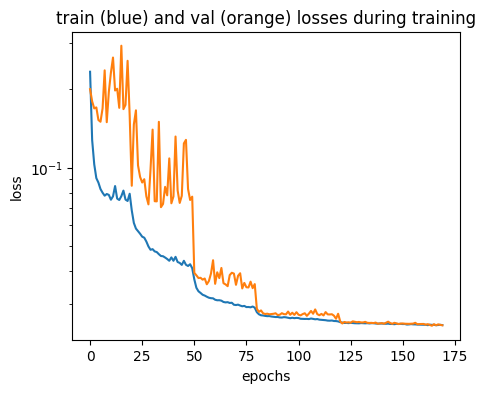

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_title("train (blue) and val (orange) losses during training")
ax.plot(train_dict["losses_train"], c="tab:blue")
ax.plot(train_dict["losses_val"], c="tab:orange")
ax.set_yscale("log")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")

## Section 5: **Results**

In [ ]:
#!cp "/content/drive/My Drive/Colab_Notebooks/progetto_asperti/KD_student.ckpt" "KD_student.ckpt"

# load model checkpoint
teacher_net = modified_resnet18(pretrained=True).to(device)
student_net = modified_resnet18(pretrained=False).to(device)

for param in teacher_net.parameters():
    param.requires_grad = False
_ = teacher_net.eval() # teacher model will always remain in eval mode

student_net.load_state_dict(torch.load(f"checkpoints/{name_train}.ckpt"))

<All keys matched successfully>

In [ ]:
def test_student_model(model_t,
                       model_s,
                       dataloader,
                       device):
    """Student model test."""

    inputs = []
    labels = []
    masks = []
    losses = []
    anomaly_maps = []

    model_s.eval()
    with torch.no_grad():
        for idx_batch, (x, y, mask) in enumerate(dataloader):

            # forward pass
            features_t = model_t(x.to(device))
            features_s = model_s(x.to(device))

            a_map = compute_anomaly_maps(features_s, features_t)
            a_map = gaussian_filter(a_map, sigma=3, axes=(1,2))

            inputs.extend(x.cpu().detach().numpy())
            labels.extend(y.cpu().detach().numpy())
            masks.extend(mask.squeeze().cpu().detach().numpy())
            anomaly_maps.extend(a_map)

    return {"inputs": np.array(inputs),
            "masks": np.array(masks),
            "labels": np.array(labels),
            "anomaly_maps": np.array(anomaly_maps),
            "avg_anomaly": np.mean(anomaly_maps, axis=(1,2)),
            "anomaly_peak": np.max(anomaly_maps, axis=(1,2))
            }

In [ ]:
results = test_student_model(teacher_net,
                             student_net,
                             test_dl,
                             device)

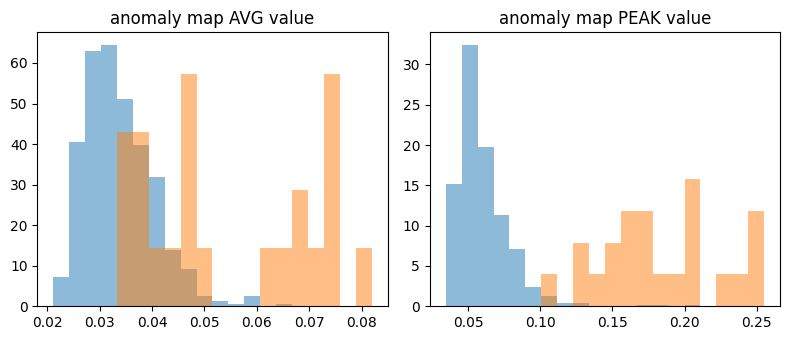

In [ ]:
def plot_multi_hist(ax, data, labels, title, **kwargs):
    limits = [np.min(data), np.max(data)]
    ax.hist(data[labels==0], color="tab:blue",
            range=limits, density=True, **kwargs)
    ax.hist(data[labels==1], color="tab:orange",
            range=limits, density=True, **kwargs)
    ax.set_title(title)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5), tight_layout=True)
plot_multi_hist(ax[0], results["avg_anomaly"], results["labels"], "anomaly map AVG value", bins=20, alpha=0.5)
plot_multi_hist(ax[1], results["anomaly_peak"], results["labels"], "anomaly map PEAK value", bins=20, alpha=0.5)

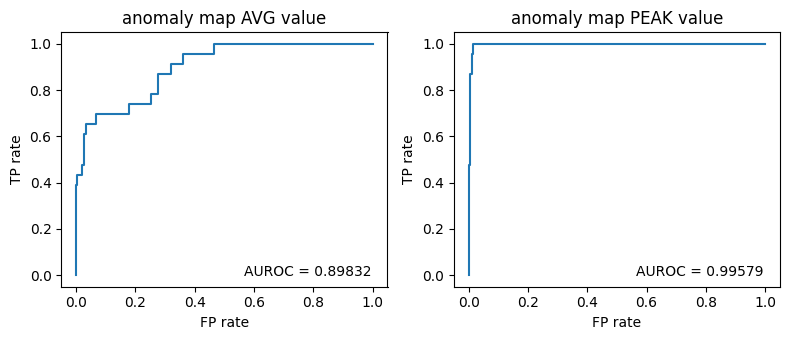

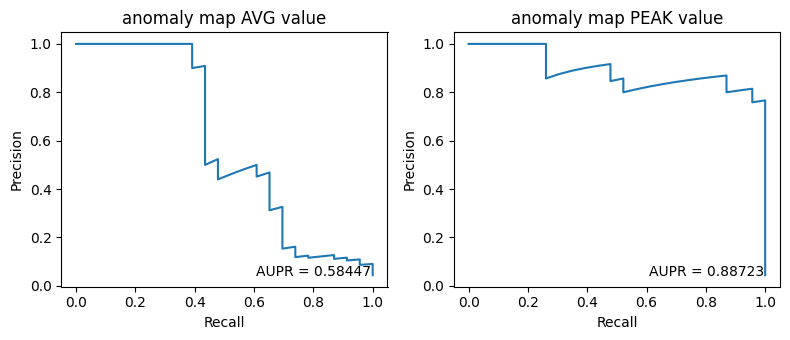

In [ ]:
def plot_roc_curve(ax, data, labels, title, **kwargs):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(labels, data)
    # Compute AUC
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, **kwargs)
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.set_title(title)
    ax.text(s = f"AUROC = {roc_auc:.5f}", x=0.95, y=0.03,
            horizontalalignment='right', verticalalignment='bottom',
            transform=ax.transAxes, fontsize=10)

def plot_pr_curve(ax, data, labels, title, **kwargs):
    # Compute ROC curve
    prec, rec, thresholds = precision_recall_curve(labels, data, drop_intermediate=True)

    # Compute AUC
    pr_auc = auc(rec, prec)

    ax.plot(rec, prec, **kwargs)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.text(s = f"AUPR = {pr_auc:.5f}", x=0.95, y=0.03,
            horizontalalignment='right', verticalalignment='bottom',
            transform=ax.transAxes, fontsize=10)


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5), tight_layout=True)
plot_roc_curve(ax[0], results["avg_anomaly"], results["labels"], "anomaly map AVG value")
plot_roc_curve(ax[1], results["anomaly_peak"], results["labels"], "anomaly map PEAK value")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5), tight_layout=True)
plot_pr_curve(ax[0], results["avg_anomaly"], results["labels"], "anomaly map AVG value")
plot_pr_curve(ax[1], results["anomaly_peak"], results["labels"], "anomaly map PEAK value")

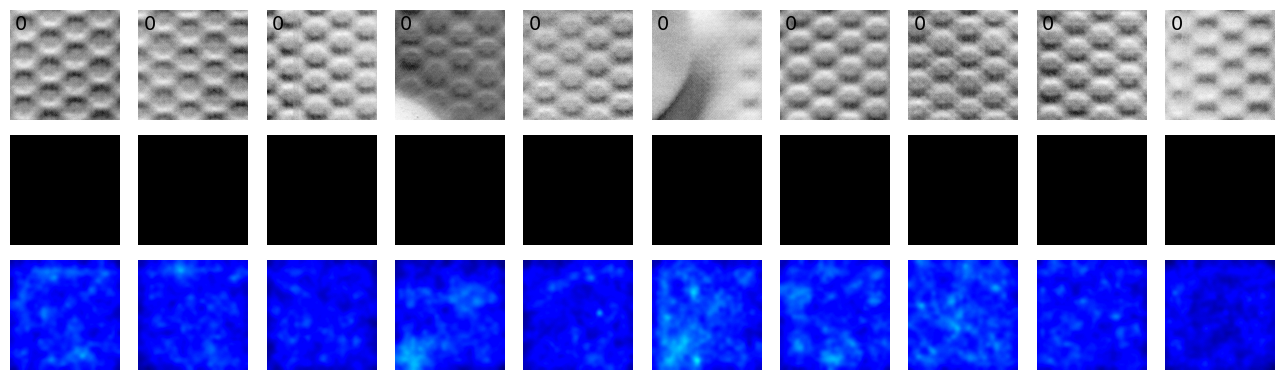

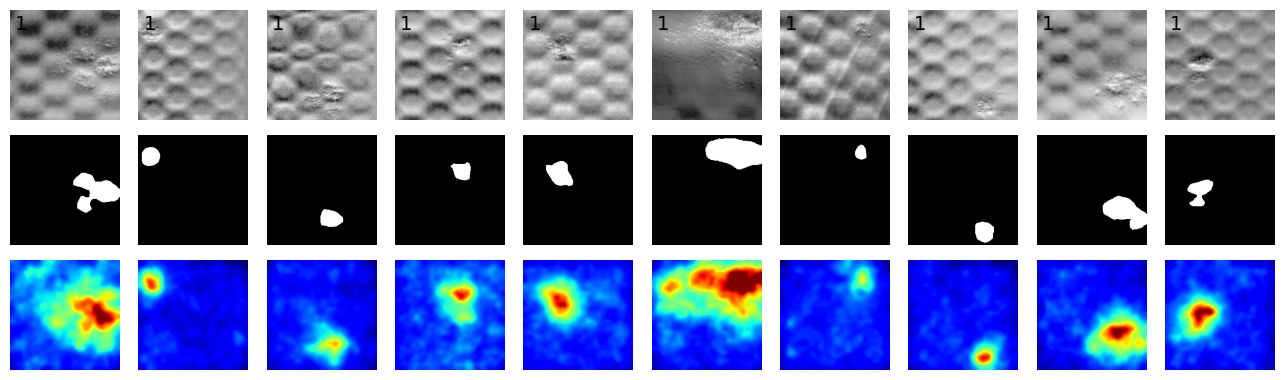

In [ ]:
def plot_results_examples(results, N=10):

    idxs_0 =  np.nonzero(results['labels']==0)[0]
    idxs_1 = np.nonzero(results['labels']==1)[0]

    vmin = np.quantile(results["anomaly_maps"].reshape(-1)[:], 0.001)
    vmax = np.quantile(results["anomaly_maps"].reshape(-1)[:], 0.999)


    # normal examples
    fig, ax = plt.subplots(ncols=N, nrows=3, figsize=(N*1.3, 3.9), tight_layout=True)
    for i in range(N):
        idx = idxs_0[i]
        ax[0,i].imshow(results["inputs"][idx][0], cmap="Greys")
        ax[0,i].text(s=f"{results['labels'][idx]}", x=10, y=10, verticalalignment="top", fontsize=14)
        ax[1,i].imshow(results["masks"][idx], cmap="Greys_r")
        ax[2,i].imshow(results["anomaly_maps"][idx], cmap="jet", vmin=vmin, vmax=vmax);
        ax[0,i].axis("off")
        ax[1,i].axis("off")
        ax[2,i].axis("off")

    # anomalous examples
    fig, ax = plt.subplots(ncols=N, nrows=3, figsize=(N*1.3, 3.9), tight_layout=True)
    for i in range(N):
        idx = idxs_1[i]
        ax[0,i].imshow(results["inputs"][idx][0], cmap="Greys")
        ax[0,i].text(s=f"{results['labels'][idx]}", x=10, y=10, verticalalignment="top", fontsize=14)
        ax[1,i].imshow(results["masks"][idx], cmap="Greys_r")
        ax[2,i].imshow(results["anomaly_maps"][idx], cmap="jet", vmin=vmin, vmax=vmax);
        ax[0,i].axis("off")
        ax[1,i].axis("off")
        ax[2,i].axis("off")


plot_results_examples(results)